# Using Qubit Components

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lightworks as lw
from lightworks import emulator

# Define backend to use for all simulations here
backend = emulator.Backend("permanent")

## Utilising Qubit Gates
All qubit components are in a dedicated 'qubit' sub-module of Lightworks. To access these, we can either use the existing Lightworks import or perform a dedicated import of the qubit module. As an example, to create a hadamard gate, either of the following would be valid.

In [2]:
hadamard = lw.qubit.H()

from lightworks import qubit  # Could go at the top of the notebook

hadamard = qubit.H()

Within this notebook we will use the latter for simplicity.

All qubit components are designed to act on dual-rail encoded qubits, where a photon in the upper mode is the $\ket{0}$ state and the $\ket{1}$ mode is the lower state. This means for single qubit gates they act across two modes, dual qubit gates act across 4 modes etc... . It is assumed that the modes that the gate is acting on are adjacent to each other, so mode swaps may be required if this is not the case.

Below, a circuit is created to support a single qubit, with each mode labelled, and the Hadamard gate is applied. This is then simulated to check the expected outputs, and it can be seen how this varies depending on whether the $\ket{0}$ or $\ket{1}$ state is input into the system.

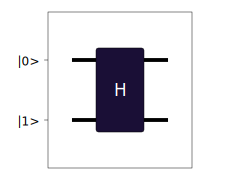

,"|1,0>","|0,1>"
"|1,0>",0.707107+0.000000j,0.707107+0.000000j
"|0,1>",0.707107+0.000000j,-0.707107+0.000000j


In [3]:
circuit = lw.Circuit(2)  # Dual rail circuit

circuit.add(hadamard, 0)  # Add hadamard

circuit.display(mode_labels=["|0>", "|1>"])
#                                           |0>               |1>
sim = lw.Simulator(circuit, [lw.State([1, 0]), lw.State([0, 1])])
results = backend.run(sim)

results.display_as_dataframe()

## Single Qubit Gates
As mentioned, single qubit gates act across a pair of modes which encode a dual-rail encoded qubit. When adding these gates, it is important they are not used to mix modes which encode two different qubits as this creates an invalid result. 

The gates currently included in Lightworks are H, X, Y, Z, T and S, below these are applied across 3 different qubits, labelled A, B & C.

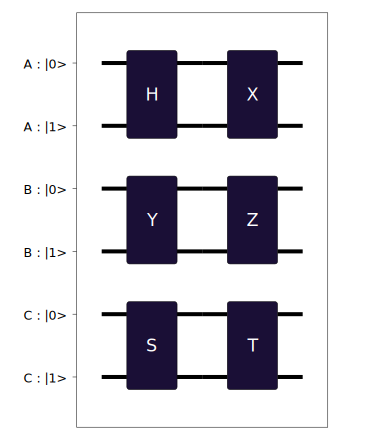

In [4]:
circuit = lw.Circuit(6)

# Qubit A
circuit.add(qubit.H(), 0)
circuit.add(qubit.X(), 0)

# Qubit B
circuit.add(qubit.Y(), 2)
circuit.add(qubit.Z(), 2)

# Qubit C
circuit.add(qubit.S(), 4)
circuit.add(qubit.T(), 4)

circuit.display(
    mode_labels=[
        "A : |0>",
        "A : |1>",
        "B : |0>",
        "B : |1>",
        "C : |0>",
        "C : |1>",
    ]
)

## Two Qubit Gates
With two qubit gates, it is often more complicated as they typically require some sort of post-selection or heralding. Lightworks aims to make this easier by including integration of the heralding modes/photons within the circuit, meaning these can automatically be applied to simulation inputs and routed around when adding new components to the circuit. Depending on the component, however, some additional post-selection may still be required, information on this can be found in the documentation or the component docstring.

To get started, below we create a 2 qubit CNOT gate. It can be seen how the heralds are shown on the upper and lower parts of the component, but not included within the main circuit modes. This particular gate requires post-selection on measuring 1 photon across the control qubit modes (0 & 1) and 1 photon across the target qubit modes (2 & 3).

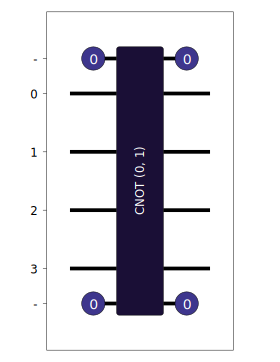

In [5]:
cnot = lw.qubit.CNOT()

cnot.display()

This CNOT gate can then be added to a circuit. In the following example, we'll aim to create the 3 qubit GHZ using a hadamard and 2 CNOTs. To start, we create the circuit, as it is a 3 qubit circuit it should have 6 modes. The H gate and CNOT are then added, it can be seen below how only the non-heralded modes of the CNOT are attached to the circuit modes.

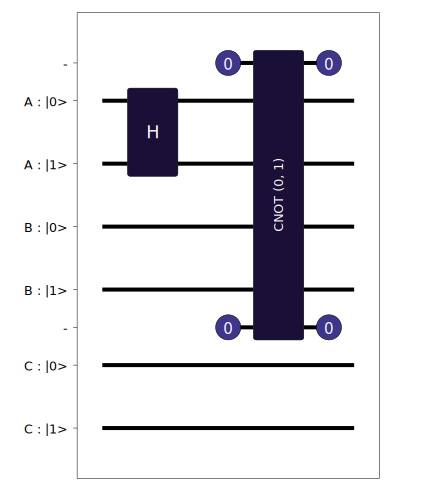

In [6]:
circ = lw.Circuit(6)
circ.add(lw.qubit.H(), 0)
circ.add(cnot, 0)

circ.display(
    mode_labels=[
        "A : |0>",
        "A : |1>",
        "B : |0>",
        "B : |1>",
        "C : |0>",
        "C : |1>",
    ]
)

A second CNOT is then integrated into the system, again this is automatically reconfigured to include the heralding requirements without these needing to be accounted for.

One question you may have is if the CNOT above requires post-selection on the output, then why are we able to cascade the CNOTs without performing post-selection between each one. This works because we only interact the A and B qubits once, meaning at the output if we measure 1 photon across A0 & A1 then we can be sure that as long as the other photon is not lost and is not on the heralding modes then the gate worked correctly.

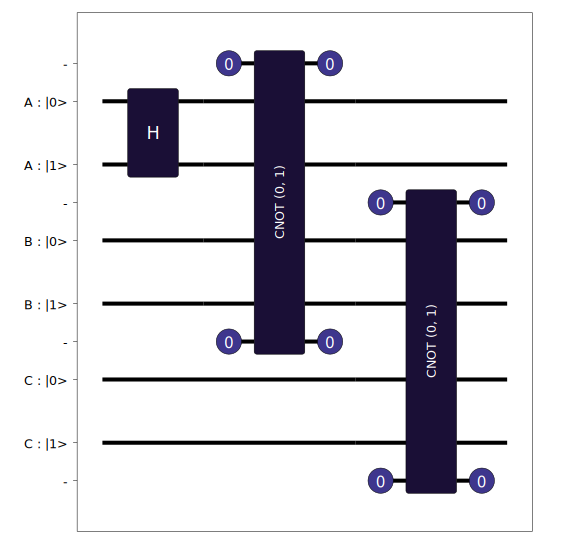

In [7]:
circ.add(cnot, 2)

circ.display(
    mode_labels=[
        "A : |0>",
        "A : |1>",
        "B : |0>",
        "B : |1>",
        "C : |0>",
        "C : |1>",
    ]
)

Once the system has been configured, it can be simulated through creation of a new Sampler object.

In [8]:
post_select = lw.PostSelection()
post_select.add((0, 1), 1)
post_select.add((2, 3), 1)
post_select.add((4, 5), 1)

sampler = lw.Sampler(
    circ, lw.State([1, 0, 1, 0, 1, 0]), 10000, post_selection=post_select
)

A number of samples are then measured from the system, and we apply a post-selection function to require only 1 photon is measured across each pair of photons corresponding to a qubit.

In [9]:
results = backend.run(sampler)

The results can then be viewed, as expected only the states $\ket{1,0,1,0,1,0}$ and $\ket{0,1,0,1,0,1}$ are measured, which correspond to the two expected measurements of the GHZ state, $\ket{0,0,0}$ and $\ket{1,1,1}$ respectively. 

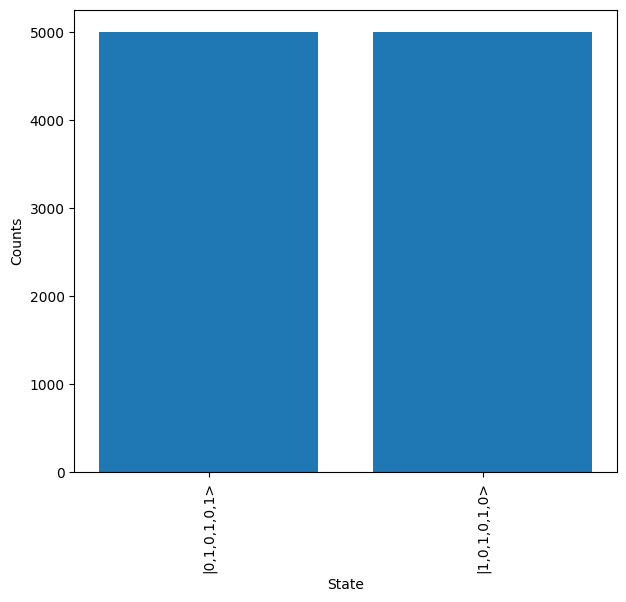

In [10]:
results.plot()

## Three Qubit Gates

The Toffoli (CCNOT) & CCZ three qubit gates are also included within Lightworks. Similar to the two qubit gates above these require post-selection on measuring one photon across each of the qubit modes.

In this tutorial we will look at the action of the CCNOT gate, which is created and displayed below.

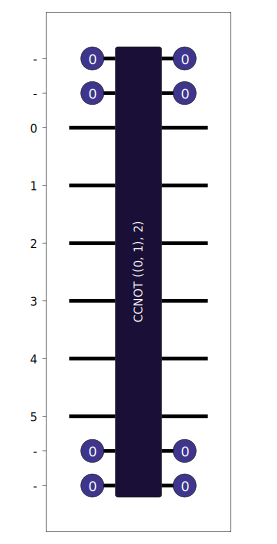

In [11]:
gate = lw.qubit.CCNOT()

gate.display()

Each of the possible valid input and outputs can then be simulated to view the action of the gate. We'll define a function to make it easier to go between qubit and mode configurations of the qubit.

In [12]:
def qubit_to_mode(qubit_state):
    mode_state = []
    for q in qubit_state:
        mode_state += [1, 0] if q == "0" else [0, 1]
    return mode_state

After completion of the simulation, the data is extracted into an array in the order defined in all_inputs.

In [13]:
# Define qubit inputs
all_inputs = ["000", "001", "100", "101", "010", "011", "110", "111"]

# Convert to mode values
mapping = {i: lw.State(qubit_to_mode(i)) for i in all_inputs}

# Simulate all combinations
sim = lw.Simulator(gate, list(mapping.values()), list(mapping.values()))
results = backend.run(sim)

# Extract all results int array
array = np.zeros((len(all_inputs), len(all_inputs)), dtype=complex)
for i, si in enumerate(all_inputs):
    for j, sj in enumerate(all_inputs):
        array[i, j] = results[mapping[si], mapping[sj]]

It can then be seen how a swap only takes place when both of the control qubits are in the 1 state.

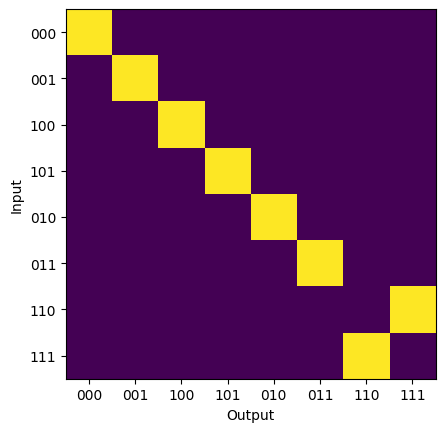

In [14]:
plt.imshow(abs(array) ** 2)
plt.xticks(range(len(all_inputs)), all_inputs)
plt.yticks(range(len(all_inputs)), all_inputs)
plt.ylabel("Input")
plt.xlabel("Output")
plt.show()